## Preprocssing & QC

In [1]:
import pandas as pd
import os
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

### 1. Loading Samples
The first step here is to load the samples that we have as raw data dge.tsv.gz in scanpy. 
They where preprared in subfolders each carrying their sample name.

Info: Content of dge.tsv.gz:

This file contains a matrix where:
Rows represent genes and columns represent cells.
    
The values in the matrix represent the expression levels (counts of RNA transcripts) of each gene in each cell.

In [4]:
#samples_dir = './samples'

So I converted them previously in the command line to .h5ad Anndata files and saved them to /raw_data dir but alternatively we could just load them as .tsv df and 
using the sc.Anndata() function convert them to Anndata object.

Now I want to load all the samples that we have in one huge Anndata list to the pp & qc steps all at once

In [4]:
# function to load the samples in batches, for memory efficiency purposes

def load_h5ad_files_in_batches(raw_data_dir, batch_size=10):
    adata_list = []
    all_files = [f for f in os.listdir(raw_data_dir) if f.endswith(".h5ad")]
    
    # process files in batches
    for i in range(0, len(all_files), batch_size):
        batch_files = all_files[i:i+batch_size]  # Get the current batch of files
        print(f"Processing batch {i // batch_size + 1}: {batch_files}")
        
        batch_list = []
        for file in batch_files:
            file_path = os.path.join(raw_data_dir, file)
            print(f"Loading {file_path}...")

            # load the .h5ad file into an AnnData object
            adata = sc.read_h5ad(file_path).T
            
            # extract the sample name from the file name (without extension)
            sample_name = os.path.splitext(file)[0]
            
            # add the 'Sample' column to the AnnData object
            adata.obs['Sample'] = sample_name
            
            # append each AnnData object to the batch list
            batch_list.append(adata)

        # process the current batch (e.g., append to master list or perform analysis)
        adata_list.extend(batch_list)
        
        # clear the batch_list to free memory if not needed further
        batch_list = []
    
    return adata_list

In [5]:
raw_data_dir = 'raw_data'
adata_list = load_h5ad_files_in_batches(raw_data_dir, batch_size=10)

Processing batch 1: ['Hs_SAT_SVF_235-1A-2.h5ad', 'Mm_POV_04-1.h5ad', 'Hs_SAT_SVF_235-2A-1.h5ad', 'Hs_SAT_SVF_237-2A-1.h5ad', 'Hs_SAT_10-1.h5ad', 'Hs_SAT_SVF_238-1A-1.h5ad', 'Hs_OAT_10-1.h5ad', 'Mm_ING_12-1.h5ad', 'Hs_SAT_266-1.h5ad', 'Mm_ING_13-1.h5ad']
Loading raw_data/Hs_SAT_SVF_235-1A-2.h5ad...
Loading raw_data/Mm_POV_04-1.h5ad...
Loading raw_data/Hs_SAT_SVF_235-2A-1.h5ad...
Loading raw_data/Hs_SAT_SVF_237-2A-1.h5ad...
Loading raw_data/Hs_SAT_10-1.h5ad...
Loading raw_data/Hs_SAT_SVF_238-1A-1.h5ad...
Loading raw_data/Hs_OAT_10-1.h5ad...
Loading raw_data/Mm_ING_12-1.h5ad...
Loading raw_data/Hs_SAT_266-1.h5ad...
Loading raw_data/Mm_ING_13-1.h5ad...
Processing batch 2: ['Hs_SAT_SVF_239-3BC-1.h5ad', 'Mm_ING_16-1.h5ad', 'Hs_SAT_SVF_239-1B-2.h5ad', 'Hs_SAT_253-1.h5ad', 'Mm_EPI_11-1.h5ad', 'Mm_EPI_10-2.h5ad', 'Mm_ING_17-1.h5ad', 'Hs_OAT_12-1.h5ad', 'Hs_SAT_01-1.h5ad', 'Hs_SAT_SVF_249-1B-1.h5ad']
Loading raw_data/Hs_SAT_SVF_239-3BC-1.h5ad...
Loading raw_data/Mm_ING_16-1.h5ad...
Loading raw_d

In [8]:
# so we end up with this long list of all Anndata objects
adata_list

[AnnData object with n_obs × n_vars = 632 × 19817
     obs: 'Sample',
 AnnData object with n_obs × n_vars = 19960 × 26275
     obs: 'Sample',
 AnnData object with n_obs × n_vars = 2451 × 23454
     obs: 'Sample',
 AnnData object with n_obs × n_vars = 1483 × 21465
     obs: 'Sample',
 AnnData object with n_obs × n_vars = 862 × 17227
     obs: 'Sample',
 AnnData object with n_obs × n_vars = 3029 × 23635
     obs: 'Sample',
 AnnData object with n_obs × n_vars = 10486 × 26159
     obs: 'Sample',
 AnnData object with n_obs × n_vars = 8611 × 25663
     obs: 'Sample',
 AnnData object with n_obs × n_vars = 7363 × 25176
     obs: 'Sample',
 AnnData object with n_obs × n_vars = 8424 × 25939
     obs: 'Sample',
 AnnData object with n_obs × n_vars = 1702 × 20041
     obs: 'Sample',
 AnnData object with n_obs × n_vars = 9973 × 26430
     obs: 'Sample',
 AnnData object with n_obs × n_vars = 2144 × 22213
     obs: 'Sample',
 AnnData object with n_obs × n_vars = 2940 × 20989
     obs: 'Sample',
 AnnDa

#### Function: `qc(adata)`

This function performs quality control (QC) on `AnnData` object (`adata`). The steps include:

1. **Cell Filtering**: Cells with fewer than 200 detected genes are filtered out to ensure minimum quality.
2. **Gene Categorization**: Mitochondrial (`MT-`), ribosomal (`RPS`, `RPL`), and hemoglobin (`HB`) genes are identified and labeled in `adata.var`.
3. **QC Metrics Calculation**: Quality control metrics, including the percentage of mitochondrial, ribosomal, and hemoglobin gene counts, are calculated for each cell. 
4. **Cleanup**: Removes redundant QC columns (`total_counts` and `log1p_total_counts`) from `adata.obs`.
5. **LAM Cell Identification**: Checks for the presence of predefined **LAM (Lipid-Associated Macrophage)** marker genes and flags cells as `LAM_cells` based on marker expression.

The function returns the updated `AnnData` object with the new QC metrics and LAM cell labels.

I regreted the **LAM Cell Identification** step later as it's too early to detect the LAM cells. So I kept it in the adata but removed it after the integration and created another one after clustering.

In [6]:
'''
Courtesy: https://www.sanbomics.com/teaching/
'''
def qc(adata):
    lam_markers = ['TREM2', 'CD9', 'LPL', 'APOE', 'LRP1', 'APP', 'LGALS3', 'LIPA']
    
    # filter for minimum genes
    sc.pp.filter_cells(adata, min_genes=200)
    
    # identifying mitochondrial, ribosomal, and hemoglobin genes
    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    adata.var['ribo'] = adata.var_names.str.startswith(('RPS', 'RPL'))
    adata.var['hb'] = adata.var_names.str.contains(('^HB[^(P)]'))
    
    # calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo', 'hb'], inplace=True, percent_top=[20], log1p=True)
    
    # remove unnecessary QC columns
    remove = ['total_counts_mt', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo',
              'total_counts_hb', 'log1p_total_counts_hb']
    adata.obs = adata.obs[[x for x in adata.obs.columns if x not in remove]]
    
    # ensure lam_markers are in var_names
    valid_markers = [gene for gene in lam_markers if gene in adata.var_names]
    if valid_markers:
        adata.obs['LAM_cells'] = adata[:, valid_markers].X.sum(axis=1) > 0
    else:
        print(f"None of the LAM markers {lam_markers} are present in the dataset.")
        adata.obs['LAM_cells'] = False  
    
    return adata

In [7]:
adata_list = [qc(ad) for ad in adata_list]

None of the LAM markers ['TREM2', 'CD9', 'LPL', 'APOE', 'LRP1', 'APP', 'LGALS3', 'LIPA'] are present in the dataset.
None of the LAM markers ['TREM2', 'CD9', 'LPL', 'APOE', 'LRP1', 'APP', 'LGALS3', 'LIPA'] are present in the dataset.
None of the LAM markers ['TREM2', 'CD9', 'LPL', 'APOE', 'LRP1', 'APP', 'LGALS3', 'LIPA'] are present in the dataset.
None of the LAM markers ['TREM2', 'CD9', 'LPL', 'APOE', 'LRP1', 'APP', 'LGALS3', 'LIPA'] are present in the dataset.
None of the LAM markers ['TREM2', 'CD9', 'LPL', 'APOE', 'LRP1', 'APP', 'LGALS3', 'LIPA'] are present in the dataset.
None of the LAM markers ['TREM2', 'CD9', 'LPL', 'APOE', 'LRP1', 'APP', 'LGALS3', 'LIPA'] are present in the dataset.
None of the LAM markers ['TREM2', 'CD9', 'LPL', 'APOE', 'LRP1', 'APP', 'LGALS3', 'LIPA'] are present in the dataset.
None of the LAM markers ['TREM2', 'CD9', 'LPL', 'APOE', 'LRP1', 'APP', 'LGALS3', 'LIPA'] are present in the dataset.
None of the LAM markers ['TREM2', 'CD9', 'LPL', 'APOE', 'LRP1', 

This line concatenates the `.obs` attribute (cell metadata) from multiple `AnnData` objects in `adata_list` into a single `pandas DataFrame` (`df`). Each `AnnData` object contains observations (cells), and this step combines the metadata for all cells across the different datasets into one DataFrame, which can then be used for further analysis or inspection.

We need the data in one single Pandas df to run the QC metrics and visualize the distribution of these QC metrics Across Samples.

In [18]:
df = pd.concat([x.obs for x in adata_list])

In [19]:
df1 = df.sort_values('Sample')
df1

,Sample,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb,LAM_cells
CATCAAGCAGGATGAC,Hs_OAT_01-1,3597,3597,8.188133,7846.0,8.967887,14.121846,1.223553,0.433342,0.012745,True
GTAACCAAGCTCCCTT,Hs_OAT_01-1,1944,1944,7.573017,3384.0,8.127110,10.786052,0.738771,0.325059,0.000000,True
GTAACCAAGCCACAAG,Hs_OAT_01-1,3143,3143,8.053251,6801.0,8.824972,14.733127,3.940597,0.499926,0.044111,True
GTAACACGTGCCTTCT,Hs_OAT_01-1,5199,5199,8.556414,15486.0,9.647757,11.113264,4.701020,0.555340,0.025830,True
GTAACACGTGAGATAT,Hs_OAT_01-1,2383,2383,7.776535,3870.0,8.261269,9.276486,1.111111,0.258398,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...
TTCACCGAGCAATTAG,Mm_POV_04-1,840,840,6.734592,1382.0,7.232010,23.082489,0.000000,0.000000,0.000000,False
ATGGGTTAGACGCCAA,Mm_POV_04-1,617,617,6.426488,961.0,6.869014,21.748179,0.000000,0.000000,0.000000,False
TTCCTAACAAAGGCTG,Mm_POV_04-1,287,287,5.662960,464.0,6.142037,36.206897,0.000000,0.000000,0.000000,False
CCTGCATCAGACGCTC,Mm_POV_04-1,819,819,6.709304,1233.0,7.118016,18.085969,0.000000,0.000000,0.000000,False


In [24]:
df1.to_csv('adatas_df.csv', index=True)

### 2. Visualizing Distribution of a Quality Metric Across Samples

This cell generates a faceted kernel density estimate (KDE) plot to visualize the distribution of a selected quality metric (`value`) across different samples using **Seaborn** and **Matplotlib**.

- **Sorting**: `df` is sorted by the 'Sample' column to ensure samples are ordered consistently.
- **Seaborn FacetGrid**: A `FacetGrid` is created with rows corresponding to different samples, and each sample is assigned a different color using the `tab20` palette.
- **KDE Plotting**:
  - The `value` column (e.g. percentage of mitochondrial counts, number of genes, etc.) is plotted as a KDE for each sample, filled with color and outlined in white for clarity.
  - A horizontal line is drawn at `y=0` to mark the baseline.
- **Labeling**: Each subplot is labeled with the corresponding sample name.
- **Customization**:
  - The y-axis is hidden for clarity, and unnecessary spines are removed.
  - A red vertical line is added at the median value of each sample's distribution to show central tendency.
- **Display**: Finally, the plot is shown using `plt.show()`, with adjusted spacing between the subplots to avoid overlap.

This visualization helps in comparing how a chosen metric varies across different samples in a clean and interpretable manner.

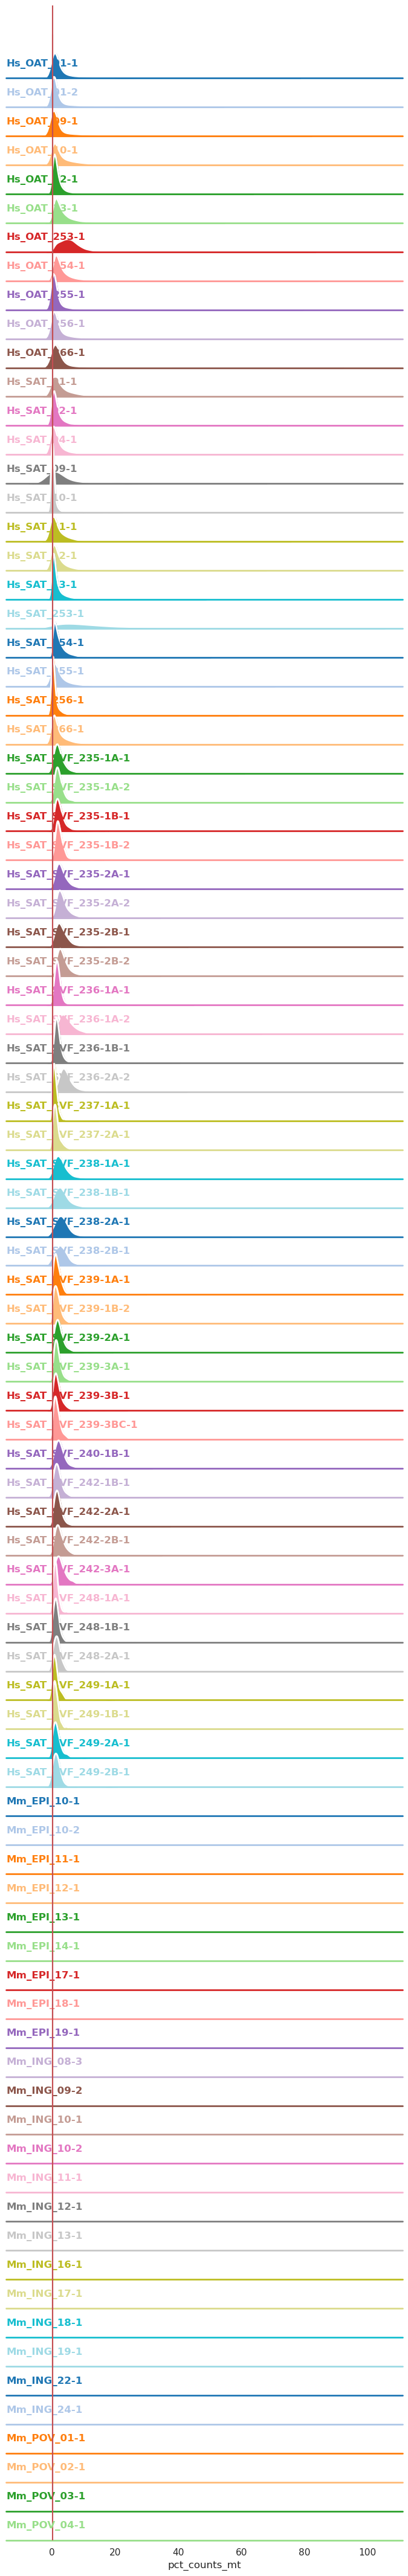

In [26]:
df = df1.sort_values('Sample')
value = "pct_counts_mt"
#value = "n_genes"
#value = 'pct_counts_in_top_20_genes'
#value = "log1p_total_counts"

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = sns.FacetGrid(df, row="Sample", hue="Sample", aspect=15, height=0.5, palette="tab20")

g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)

g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, value)

g.figure.subplots_adjust(hspace=-.6)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

for ax in g.axes.flat:
    ax.axvline(x=df[value].median(), color='r', linestyle='-')


plt.show()

In [10]:
len(adata_list)

86

In [29]:

adata_list[-1].obs

,Sample,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb,LAM_cells
CTACAGAGTTACGTAC,Mm_POV_02-1,8164,8164,9.007612,44950.0,10.713328,11.563960,0.0,0.0,0.0,False
GTCTTTAGTCGGTGTC,Mm_POV_02-1,7265,7265,8.890961,42719.0,10.662422,16.706852,0.0,0.0,0.0,False
TTAGGCACACCTGTCT,Mm_POV_02-1,5881,5881,8.679652,36250.0,10.498222,19.307586,0.0,0.0,0.0,False
GATTGGTCATAGACTC,Mm_POV_02-1,5902,5902,8.683216,36106.0,10.494242,18.780812,0.0,0.0,0.0,False
CACTTCGAGGTTCCAT,Mm_POV_02-1,7342,7342,8.901503,35793.0,10.485536,13.466320,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...
TTCAATCCAAGAAATC,Mm_POV_02-1,402,402,5.998937,495.0,6.206576,15.757576,0.0,0.0,0.0,False
TTCTAGTTCAGTGTCA,Mm_POV_02-1,224,224,5.416100,256.0,5.549076,19.140625,0.0,0.0,0.0,False
ACATCGAAGCACGGAT,Mm_POV_02-1,313,313,5.749393,396.0,5.983936,18.434343,0.0,0.0,0.0,False
CATCGGGCACACCAGC,Mm_POV_02-1,234,234,5.459586,283.0,5.648974,20.494700,0.0,0.0,0.0,False


#### Splitting Data into Human and Mouse Samples

This code separates the combined `AnnData` objects in `adata_list` into two lists: one for human samples (`human_adata_list`) and one for mouse samples (`mouse_adata_list`). 

- **Human Samples**: 
  - The `obs['Sample']` field is checked for entries starting with `'Hs_'` (indicating human samples). If any human cells are present (`n_obs > 0`), the subset is added to `human_adata_list`.
  
- **Mouse Samples**: 
  - Similarly, the `obs['Sample']` field is checked for entries starting with `'Mm_'` (indicating mouse samples). If any mouse cells are present, the subset is added to `mouse_adata_list`.

This creates two separate lists of `AnnData` objects for further analysis, one for each species.

I've decided at this point to only work with human samples given that we have many samples in the dataset

In [8]:
# split the data into human and mouse samples
human_adata_list = []
mouse_adata_list = []

for adata in adata_list:
    # filter for human samples (Sample starts with 'Hs_')
    human_adata = adata[adata.obs['Sample'].str.startswith('Hs_')]
    if human_adata.n_obs > 0:  # only keep if it has data
        human_adata_list.append(human_adata)
    
    # filter for mouse samples (Sample starts with 'Mm_')
    mouse_adata = adata[adata.obs['Sample'].str.startswith('Mm_')]
    if mouse_adata.n_obs > 0:  # only keep if it has data
        mouse_adata_list.append(mouse_adata)

In [11]:
for i, adata in enumerate(adata_list):
    adata.write(f'processed/adata_object_{i}.h5ad')

---

### 3. Double Detection

In [9]:
import doubletdetection
from scipy.stats import median_abs_deviation as mad
import numpy as np

This following function detects outliers in the `AnnData` object (`adata`) based on the **Median Absolute Deviation (MAD)** method, as described by Germain et al. in Genome Biology (2020).

- **Parameters**:
  - `adata`: The `AnnData` object containing the data.
  - `metric`: The column in `adata.obs` representing the quality control metric (e.g., `pct_counts_mt`) to check for outliers.
  - `nmads`: The number of MADs (Median Absolute Deviations) to use as a threshold for defining outliers.
  - `upper_only`: If set to `True`, only detects outliers above the upper threshold (ignores lower outliers).

- **Logic**:
  - If `upper_only=False`, the function flags outliers both above and below the median using the MAD method:
    - Outliers are those where the value is either:
      - Lower than the median minus `nmads * MAD`, or
      - Higher than the median plus `nmads * MAD`.
  - If `upper_only=True`, the function only flags outliers above the upper threshold.

The function returns a boolean mask that identifies the cells flagged as outliers based on the given metric and thresholds.

In [10]:
def mad_outlier(adata, metric, nmads, upper_only = False):
    M = adata.obs[metric]
    
    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))
    
    return (M > np.median(M) + nmads * mad(M))

#### Initializing the `BoostClassifier` for Doublet Detection

This line initializes a **BoostClassifier** from the `doubletdetection` package to identify potential doublets in our data.

- **Parameters**:
  - `n_iters=10`: The number of iterations to run the doublet detection algorithm, helping improve robustness of the results.
  - `clustering_algorithm="louvain"`: The clustering algorithm used to partition cells before detecting doublets. Here, the Louvain algorithm is selected for clustering.
  - `standard_scaling=True`: Enables scaling of the gene expression data to standardize it, which can improve the performance of the classifier.
  - `pseudocount=0.1`: A small value added to the data to avoid division by zero and stabilize computations.
  - `n_jobs=-1`: Uses all available CPU cores for parallel computation to speed up processing.

This classifier will then be used to predict doublets in the dataset.

In [11]:
clf = doubletdetection.BoostClassifier(
    n_iters=10,
    clustering_algorithm="louvain",
    standard_scaling=True,
    pseudocount=0.1,
    n_jobs=-1)

**Putting all together**

The following function preprocesses an `AnnData` object (`adata`) to filter out low-quality cells and identify potential doublets.

- **Quality Control**:
  - **Mitochondrial Percentage Filter**: Cells are filtered to retain only those with less than 25% mitochondrial gene expression (`pct_counts_mt < 25`). This threshold can be adjusted based on the dataset's overall distribution.
  
  - **Outlier Detection**: A boolean vector (`bool_vector`) is created to identify outliers using the **Median Absolute Deviation (MAD)** method for the following metrics:
    - `log1p_total_counts`
    - `log1p_n_genes_by_counts`
    - `pct_counts_in_top_20_genes`
    - `pct_counts_mt` (considering only upper outliers with a threshold of 3)
  
  - Cells flagged as outliers are removed from `adata`.

- **Doublet Detection**:
  - The classifier (`clf`, previously initialized) is fitted to the filtered data, and potential doublets are predicted using a probability threshold of `1e-3` and a voter threshold of `0.5`.
  - The doublet scores are also calculated and stored.

- **Data Management**:
  - The total number of removed cells and detected doublets is recorded in the `.uns` attribute.
  - Cells identified as doublets (`doublet == 1`) are removed from `adata`.

The function returns the cleaned `AnnData` object with low-quality cells and doublets filtered out, ready for further analysis.

In [12]:
def pp(adata):
    adata = adata[adata.obs.pct_counts_mt < 25] #you can lower this based on the overal distribution of your dataset
    
    bool_vector = mad_outlier(adata, 'log1p_total_counts', 5) +\
            mad_outlier(adata, 'log1p_n_genes_by_counts', 5) +\
            mad_outlier(adata, 'pct_counts_in_top_20_genes', 5) +\
            mad_outlier(adata, 'pct_counts_mt', 3, upper_only = True)
    adata = adata[~bool_vector]

    adata.uns['cells_removed'] = sum(bool_vector)

    doublets = clf.fit(adata.X).predict(p_thresh=1e-3, voter_thresh=0.5)
    doublet_score = clf.doublet_score()

    adata.obs["doublet"] = doublets
    adata.obs["doublet_score"] = doublet_score

    adata.uns['doublets_removed'] = adata.obs.doublet.sum()
    adata = adata[adata.obs.doublet == 0]

    return adata

In [13]:
# applying the steps in batches to save memory

def process_in_batches(adata_list, batch_size=5):
    results = []
    for i in range(0, len(adata_list), batch_size):
        # process a batch of AnnData objects
        batch = adata_list[i:i + batch_size]
        # apply the preprocessing function to each AnnData object in the batch
        processed_batch = [pp(ad) for ad in batch]
        results.extend(processed_batch)  # collect results
    return results

In [ ]:
adata_list1 = process_in_batches(adata_list, batch_size=5)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]